# Sawnwood flows and stocks from 1961 to 2021


In [1109]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import openpyxl
import pylab

# For Ipython Notebook only
%matplotlib inline

# Specify path to dynamic stock model and to datafile, relative
MainPath = os.path.join('..', '..', 'odym', 'modules')
#DataPath = os.path.join('..', 'docs', 'Playground_June2023')
DataPath = os.path.join('.')
sys.path.insert(0, MainPath)  # add ODYM module directory to system path

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), '..', '..', 'odym', 'modules'))
sys.path.insert(0, os.path.join(os.getcwd(), '.'))

#Current working directory
#print(os.getcwd())

# These are retrieved automatically from the Excel file
starting_year = 0
ending_year = 0

lifetime_file = 'Sawnwood_Lifetime_Europe.xlsx'
lifetime_datasheetname = "Average_lifetime"
lifetime_row_start = 2
lifetime_num_rows = 1
lifetime_row_end = lifetime_row_start + lifetime_num_rows
lifetime_col_index = 2

inflow_file = 'Sawnwood_Consumption_Final_Europe.xlsx'
inflow_datasheetname = 'FinalConsumptionSawnwood_ob_est'
inflow_row_start = 2
inflow_num_rows = 61
inflow_row_end = inflow_row_start + inflow_num_rows
inflow_col_index_region = 3
inflow_col_index_year = 4
inflow_col_product_name = 5
inflow_col_index_consumption = 6

import ODYM_Classes as msc  # import the ODYM class file
import ODYM_Functions as msf  # import the ODYM function file
import dynamic_stock_model as dsm  # import the dynamic stock model library

In [1110]:
# Specify path to dynamic stock model and to datafile, relative
import dynamic_stock_model as dsm  # import the dynamic stock model library

import openpyxl
import numpy as np
import matplotlib.pyplot as plt

# For Ipython Notebook only
%matplotlib inline

###Define MFA system
ModelClassification = {}  # Create dictionary of model classifications

# Count automatically how many years are in Excel file
file = openpyxl.load_workbook(os.path.join(DataPath, inflow_file), data_only=True)
file_datasheet = file[inflow_datasheetname]

# Get min and max years in column that contains years (inflow_col_year)
num_rows_found = 0
available_years = []
available_rows = list(file_datasheet.iter_rows())

# Detect years automatically from the file
for row in available_rows:
    # Decrease index by one because when using iterators
    # then columns start from 0, elsewhere use the initial
    # value
    value = row[inflow_col_index_year - 1].value
    if not isinstance(value, int):
        continue

    num_rows_found = num_rows_found + 1
    available_years.append(value)

# These are the minimum and maximum years found in the years column in Excel file
# Also the count of the years
starting_year = min(available_years)
ending_year = max(available_years)
num_years = len(available_years)

# Last row in the file has the line number num_rows_found
# NOTE: Excel file somehow stores empty data so if row count
# does not match then DELETE those rows and remember to SAVE the file!
inflow_row_end = inflow_row_start + num_rows_found


In [1111]:
MyYears = available_years

ModelClassification['Time'] = msc.Classification(Name='Time', Dimension='Time', ID=1,
                                                 Items=MyYears)
ModelClassification['Cohort'] = msc.Classification(Name='Age-cohort', Dimension='Time', ID=2,
                                                   Items=MyYears)
# Classification for time labelled 'Time' must always be present, with Items containing a list of ordered integers representing years, months, or other discrete time intervals
# Classification for cohort is used to track age-cohorts in the stock.

ModelClassification['Element'] = msc.Classification(Name='Elements', Dimension='Element',
                                                    ID=3, Items=['C'])
# Classification for elements labelled 'Element' must always be present, with Items containing a list of the symbols of the elements covered.

# Classification for regions is chosen to include the regions that are in the scope of this analysis.
MyRegions = ['Europe']
ModelClassification['Region'] = msc.Classification(Name='Regions', Dimension='Region', ID=4,
                                                   Items=MyRegions)

# End uses (= stocks with the lifetime)
our_end_uses = ['Value added market 1', 'Value added market 2', 'Value added market 3']
ModelClassification['Classification_name_end_uses'] = msc.Classification(Name="End uses", Dimension="End uses", ID=5, Items=our_end_uses)

# Get model time start, end, and duration:
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End = int(max(ModelClassification['Time'].Items))
Model_Duration = Model_Time_End - Model_Time_Start

In [1112]:
### That dictionary of classifications enteres the index table defined for the system. The indext table lists all aspects needed and assigns a classification and index letter to each aspect.

IndexTable = pd.DataFrame(
    {'Aspect': ['Time', 'Age-cohort', 'Element', 'Region'],  # 'Time' and 'Element' must be present!
     'Description': ['Model aspect "time"', 'Model aspect "age-cohort"', 'Model aspect "Element"',
                     'Model aspect "Region where flow occurs"'],
     'Dimension': ['Time', 'Time', 'Element', 'Region'],  # 'Time' and 'Element' are also dimensions
     'Classification': [ModelClassification[Aspect] for Aspect in ['Time', 'Cohort', 'Element', 'Region']],
     'IndexLetter': ['t', 'c', 'e',
                     'r']})  # Unique one letter (upper or lower case) indices to be used later for calculations.

IndexTable.set_index('Aspect', inplace=True)  # Default indexing of IndexTable, other indices are produced on the fly

# Our index table
index_table = pd.DataFrame(
    {'OurIndices': ['Time', 'Age-cohort', 'Element', 'End uses'],  # 'Time' and 'Element' must be present!
     'Description': ['Model aspect "time"', 'Model aspect "age-cohort"', 'Model aspect "Element"',
                     'Model aspect "End uses that contains stock with lifetime"'],
     'Dimension': ['Time', 'Time', 'Element', 'End uses'],  # 'Time' and 'Element' are also dimensions
     'Classification': [ModelClassification[Aspect] for Aspect in ['Time', 'Cohort', 'Element', 'Classification_name_end_uses']],
     'IndexLetter': ['t', 'c', 'e',
                     'u']})  # Unique one letter (upper or lower case) indices to be used later for calculations.

index_table.set_index('OurIndices', inplace=True)  # Default indexing of IndexTable, other indices are produced on the fly



In [1113]:
###Define MFA system
mfa_system = msc.MFAsystem(Name='StockAccumulationSystem',
                           Geogr_Scope='Europe',
                           Unit='m3',
                           ProcessList=[],
                           FlowDict={},
                           StockDict={},
                           ParameterDict={},
                           Time_Start=Model_Time_Start,
                           Time_End=Model_Time_End,
                           IndexTable=IndexTable,
                           Elements=IndexTable.loc['Element'].Classification.Items)

# Our MFA system
our_mfa_system = msc.MFAsystem(Name='StockAccumulationSystem',
                           Geogr_Scope='Europe',
                           Unit='m3',
                           ProcessList=[],
                           FlowDict={},
                           StockDict={},
                           ParameterDict={},
                           Time_Start=Model_Time_Start,
                           Time_End=Model_Time_End,
                           IndexTable=index_table,
                           Elements=index_table.loc['Element'].Classification.Items)



In [1114]:
###Read lifetimes from excel file

LifetimeFile = openpyxl.load_workbook(os.path.join(DataPath, lifetime_file), data_only=True)
Datasheet = LifetimeFile[lifetime_datasheetname]

Lifetimes = []

for m in range(lifetime_row_start, lifetime_row_end):
    Lifetimes.append(Datasheet.cell(m, lifetime_col_index).value)  # Add lifetime values to list

### For the inflow array, we also need to assign the flow values to the right countries:
InflowFile = openpyxl.load_workbook(os.path.join(DataPath, inflow_file), data_only=True)
Datasheet = InflowFile[inflow_datasheetname]

InflowArray = np.zeros((len(MyRegions), len(MyYears)))  # OriginRegion x Year
#print(InflowArray.shape)

for m in range(inflow_row_start, inflow_row_end):
    OriginCountryPosition = MyRegions.index(Datasheet.cell(m, inflow_col_index_region).value)
    YearPosition = MyYears.index(int(Datasheet.cell(m, inflow_col_index_year).value))
    InflowArray[OriginCountryPosition, YearPosition] = Datasheet.cell(m, inflow_col_index_consumption).value



In [1115]:
### 4) Inserting data into the MFA system
mfa_system.ProcessList = []  # Start with empty process list, only process numbers (IDs) and names are needed.
mfa_system.ProcessList.append(msc.Process(Name='Other_industries', ID=0))
mfa_system.ProcessList.append(msc.Process(Name='Consumption', ID=1))

### Now, we define the parameter values for the inflow and yield parameters:

# Print list of processes:
mfa_system.ProcessList

ParameterDict = {}

#
ParameterDict['Inflow'] = msc.Parameter(Name='Final sawnwood consumption', ID=1, P_Res=1,
                                        MetaData=None, Indices='r,t',
                                        Values=InflowArray, Unit='m3/yr')

#
ParameterDict['tau'] = msc.Parameter(Name='mean product lifetime', ID=2, P_Res=1,
                                     MetaData=None, Indices='r',
                                     Values=Lifetimes, Unit='yr')
ParameterDict['sigma'] = msc.Parameter(Name='stddev of mean product lifetime', ID=3, P_Res=1,
                                       MetaData=None, Indices='r',
                                       Values=[0.3 * i for i in Lifetimes], Unit='yr')

# Assign parameter dictionary to MFA system:
mfa_system.ParameterDict = ParameterDict

### The flows, stocks changes, and stocks are as follows:

# Define the flows of the system, and initialise their values:
mfa_system.FlowDict['F_0_1'] = msc.Flow(Name='final consumption', P_Start=0, P_End=1,
                                        Indices='t,r,e', Values=None)
mfa_system.FlowDict['F_1_0'] = msc.Flow(Name='Eol products', P_Start=1, P_End=0,
                                        Indices='t,c,r,e', Values=None)
mfa_system.StockDict['S_1'] = msc.Stock(Name='sawnwood stock', P_Res=1, Type=0,
                                        Indices='t,c,r,e', Values=None)
mfa_system.StockDict['dS_1'] = msc.Stock(Name='sawnwood stock change', P_Res=1, Type=1,
                                         Indices='t,r,e', Values=None)

mfa_system.Initialize_FlowValues()  # Assign empty arrays to flows according to dimensions.
mfa_system.Initialize_StockValues()  # Assign empty arrays to flows according to dimensions.
# Check whether flow value arrays match their indices, etc. See method documentation.
mfa_system.Consistency_Check()


(True, True, True)

In [1116]:
# 4) Insert data into our MFA system
our_mfa_system.ProcessList = []  # Start with empty process list, only process numbers (IDs) and names are needed.

# PROCESSES
# These processes will contain the stock with the lifetime
our_mfa_system.ProcessList.append(msc.Process(Name='Sawnwood consumption', ID=0))
our_mfa_system.ProcessList.append(msc.Process(Name='Value added market 1', ID=1))
our_mfa_system.ProcessList.append(msc.Process(Name='Value added market 2', ID=2))
our_mfa_system.ProcessList.append(msc.Process(Name='Value added market 3', ID=3))

# PARAMETERS
our_parameter_dict = {}

# Incoming flow of apparent consumption
# P_Res = id of process to which parameter is assigned (id: int)
our_parameter_dict['flow_to_1'] = msc.Parameter(
    Name='Final value added market 1', ID=0, P_Res=1, MetaData=None, Indices='u,t', Values=InflowArray, Unit='m3/yr')

our_parameter_dict['flow_to_2'] = msc.Parameter(
    Name='Final value added market 2', ID=1, P_Res=2, MetaData=None, Indices='u,t', Values=InflowArray, Unit='m3/yr')

our_parameter_dict['flow_to_3'] = msc.Parameter(
    Name='Final value added market 3', ID=2, P_Res=3, MetaData=None, Indices='u,t', Values=InflowArray, Unit='m3/yr')


our_parameter_dict['tau_1'] = msc.Parameter(
    Name='mean product lifetime 1', ID=3, P_Res=1, MetaData=None, Indices='r', Values=Lifetimes, Unit='yr')

our_parameter_dict['tau_2'] = msc.Parameter(
    Name='mean product lifetime 2', ID=4, P_Res=2, MetaData=None, Indices='r', Values=Lifetimes, Unit='yr')

our_parameter_dict['tau_3'] = msc.Parameter(
    Name='mean product lifetime 3', ID=5, P_Res=3, MetaData=None, Indices='r', Values=Lifetimes, Unit='yr')

our_parameter_dict['sigma_1'] = msc.Parameter(
    Name='stddev of mean product lifetime in VAM1', ID=6, P_Res=1, MetaData=None, Indices='u', Values=[0.3 * i for i in Lifetimes], Unit='yr')

our_parameter_dict['sigma_2'] = msc.Parameter(
    Name='stddev of mean product lifetime in VAM2', ID=7, P_Res=2, MetaData=None, Indices='u', Values=[0.3 * i for i in Lifetimes], Unit='yr')

our_parameter_dict['sigma_3'] = msc.Parameter(
    Name='stddev of mean product lifetime in VAM3', ID=8, P_Res=3, MetaData=None, Indices='u', Values=[0.3 * i for i in Lifetimes], Unit='yr')

# Assign parameter dictionary to MFA system:
our_mfa_system.ParameterDict = our_parameter_dict

# FLOWS
our_mfa_system.FlowDict['F_0_1'] = msc.Flow(
    Name='Consumption of sawnwood in value added market 1', P_Start=0, P_End=1, Indices='t,u,e', Values=None)

our_mfa_system.FlowDict['F_0_2'] = msc.Flow(
    Name='Consumption of sawnwood in value added market 2', P_Start=0, P_End=2, Indices='t,u,e', Values=None)

our_mfa_system.FlowDict['F_0_3'] = msc.Flow(
    Name='Consumption of sawnwood in value added market 3', P_Start=0, P_End=3, Indices='t,u,e', Values=None)

# STOCKS
our_mfa_system.StockDict['S_1'] = msc.Stock(
    Name='Sawnwood stock in value added market 1', P_Res=1, Type=0, Indices='t,c,u,e', Values=None)

our_mfa_system.StockDict['S_2'] = msc.Stock(
    Name='Sawnwood stock in value added market 2', P_Res=2, Type=0, Indices='t,c,u,e', Values=None)

our_mfa_system.StockDict['S_3'] = msc.Stock(
    Name='Sawnwood stock in value added market 3', P_Res=3, Type=0, Indices='t,c,u,e', Values=None)

our_mfa_system.Initialize_FlowValues()  # Assign empty arrays to flows according to dimensions.
our_mfa_system.Initialize_StockValues()  # Assign empty arrays to flows according to dimensions.

# Check whether flow value arrays match their indices, etc. See method documentation.
our_mfa_system.Consistency_Check()

# # Define the flows of the system, and initialise their values:
# mfa_system.FlowDict['F_1_0'] = msc.Flow(Name='Eol products', P_Start=1, P_End=0,
#                                         Indices='t,c,r,e', Values=None)
# mfa_system.StockDict['dS_1'] = msc.Stock(Name='sawnwood stock change', P_Res=1, Type=1,
#                                          Indices='t,r,e', Values=None)

(True, True, True)

In [1117]:
# 5) Programming a solution of the MFA system

# Now the system definition is complete, and we can program the model solution, making use of the dynamic_stock_model methods
# Fit model parameter 'Inflow' to right shape in FlowDict:
mfa_system.FlowDict['F_0_1'].Values[:, :, 0] = mfa_system.ParameterDict['Inflow'].Values.transpose()

# Loop over all regions to determine inflow-driven stock:
for region in np.arange(0,
                        len(MyRegions)):  # from the first region (index 0) to the last region (Python does not use the last index on the right side of an interval)
    # Create helper DSM for computing the dynamic stock model:
    DSM_Inflow = dsm.DynamicStockModel(t=np.array(MyYears),
                                       i=mfa_system.ParameterDict['Inflow'].Values[region, :],
                                       lt={'Type': 'Normal',
                                           'Mean': [mfa_system.ParameterDict['tau'].Values[region]],
                                           'StdDev': [mfa_system.ParameterDict['sigma'].Values[region]]})

    Stock_by_cohort = DSM_Inflow.compute_s_c_inflow_driven()
    O_C = DSM_Inflow.compute_o_c_from_s_c()
    S = DSM_Inflow.compute_stock_total()
    DS = DSM_Inflow.compute_stock_change()
    mfa_system.FlowDict['F_1_0'].Values[:, :, region, 0] = O_C
    mfa_system.StockDict['dS_1'].Values[:, region, 0] = DS
    mfa_system.StockDict['S_1'].Values[:, :, region, 0] = Stock_by_cohort

In [1118]:
# 5) Programming a solution of the OUR MFA system

# Now the system definition is complete, and we can program the model solution, making use of the dynamic_stock_model methods
# Fit model parameter 'Inflow' to right shape in FlowDict:
our_mfa_system.FlowDict['F_0_1'].Values[:, :, 0] = our_mfa_system.ParameterDict['flow_to_1'].Values.transpose()
our_mfa_system.FlowDict['F_0_2'].Values[:, :, 0] = our_mfa_system.ParameterDict['flow_to_2'].Values.transpose()
our_mfa_system.FlowDict['F_0_3'].Values[:, :, 0] = our_mfa_system.ParameterDict['flow_to_3'].Values.transpose()

# Loop over all regions to determine inflow-driven stock:
# from the first region (index 0) to the last region (Python does not use the last index on the right side of an interval)
for index in np.arange(0, len(our_end_uses)):
    # Create helper DSM for computing the dynamic stock model:
    DSM_Inflow = dsm.DynamicStockModel(t=np.array(MyYears),
                                       i=our_mfa_system.ParameterDict['flow_to_1'].Values[0, :],
                                       lt={'Type': 'Normal',
                                           'Mean': [our_mfa_system.ParameterDict['tau_1'].Values[0]],
                                           'StdDev': [our_mfa_system.ParameterDict['sigma_1'].Values[0]]})
                                           # 'Mean': [our_mfa_system.ParameterDict['tau_1'].Values[index]],
                                           # 'StdDev': [our_mfa_system.ParameterDict['sigma_1'].Values[index]]})

    Stock_by_cohort = DSM_Inflow.compute_s_c_inflow_driven()
    O_C = DSM_Inflow.compute_o_c_from_s_c()
    S = DSM_Inflow.compute_stock_total()
    DS = DSM_Inflow.compute_stock_change()
    # our_mfa_system.FlowDict['F_1_0'].Values[:, :, region, 0] = O_C
    # our_mfa_system.StockDict['dS_1'].Values[:, region, 0] = DS
    our_mfa_system.StockDict['S_1'].Values[:, :, index, 0] = Stock_by_cohort

# 6) Mass balance check
our_balance = our_mfa_system.MassBalance()
# print(our_balance.shape) # dimensions of balance are: time step x process x chemical element
# print(np.abs(our_balance).sum(axis = 0)) # reports the sum of all absolute balancing errors by process.

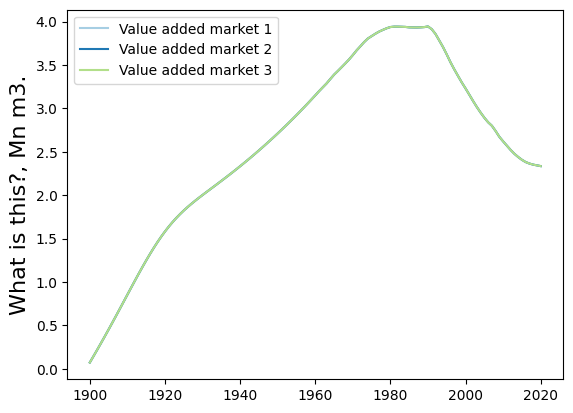

In [1119]:
# Do OUR plotting

plt.set_loglevel("info")
MyColorCycle = pylab.cm.Paired(np.arange(0, 1, 0.1))  # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
for m in range(0, len(our_end_uses)):
    ax.plot(our_mfa_system.IndexTable['Classification']['Time'].Items,
            our_mfa_system.StockDict['S_1'].Values[:, :, m, 0].sum(axis=1) / 1000,
            color=MyColorCycle[m, :])
ax.set_ylabel('What is this?, Mn m3.', fontsize=16)
ax.legend(our_end_uses, loc='upper left', prop={'size': 10})

plt.set_loglevel("info")

# FlowRatio = mfa_system.FlowDict['F_1_0'].Values[:, :, :, 0].sum(axis=1) \
#             / mfa_system.FlowDict['F_0_1'].Values[:, :, 0]
#
# FlowRatio[np.isnan(FlowRatio)] = 0  # Set all ratios where reference flow F_0_1 was zero to zero, not nan.
#
# fig, ax = plt.subplots()
# for m in range(0, len(MyRegions)):
#     ax.plot(mfa_system.IndexTable['Classification']['Time'].Items,
#             FlowRatio[:, m] * 100, color=MyColorCycle[m, :])
# ax.plot([starting_year, ending_year], [100, 100], color='k', linestyle='--')
# ax.set_ylabel('Ratio Outflow/Inflow, unit: 1.', fontsize=16)
# ax.legend(MyRegions, loc='upper left', prop={'size': 8})
#
# MyColorCycle = pylab.cm.Paired(np.arange(0, 1, 0.1))  # select 10 colors from the 'Paired' color map.
# fig, ax = plt.subplots()
# for m in range(0, len(MyRegions)):
#     ax.plot(MyYears,
#             InflowArray[0],
#             color=MyColorCycle[m, :])
# ax.set_ylabel('Consumption of Sawnwood, Mt m3.', fontsize=16)
# ax.legend(MyRegions, loc='upper left', prop={'size': 10})

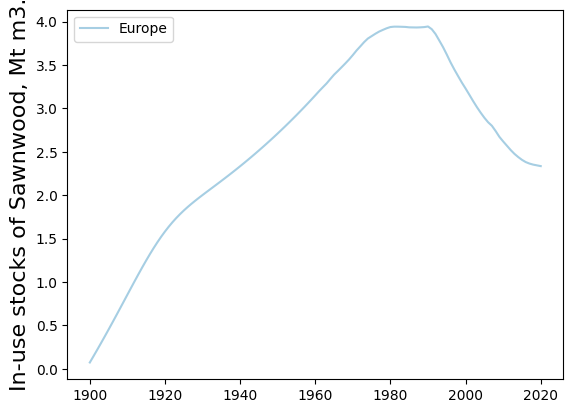

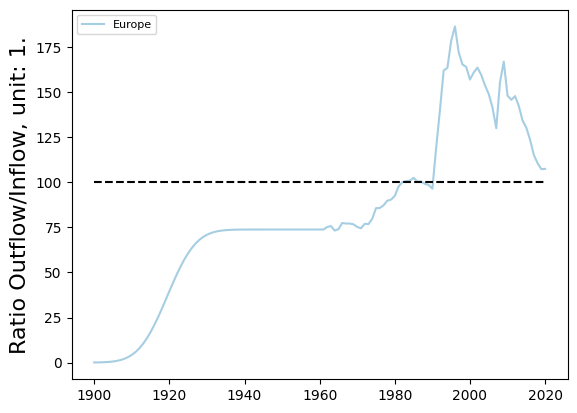

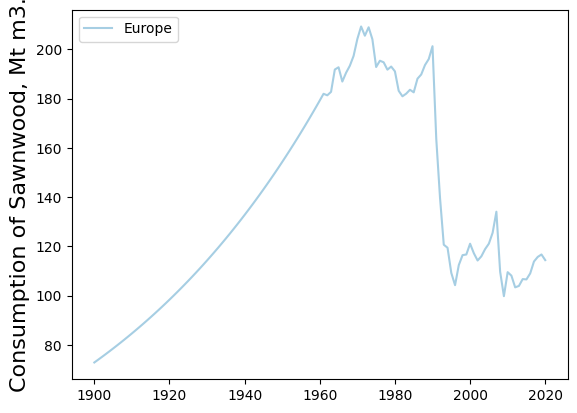

In [1120]:
### 6) Mass-balance-check

Bal = mfa_system.MassBalance()
#print(Bal.shape) # dimensions of balance are: time step x process x chemical element
#print(np.abs(Bal).sum(axis = 0)) # reports the sum of all absolute balancing errors by process.

### 7) Research questions

# In-use stocks of sawnwood, Mt m3

plt.set_loglevel("info")
MyColorCycle = pylab.cm.Paired(np.arange(0, 1, 0.1))  # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
for m in range(0, len(MyRegions)):
    ax.plot(mfa_system.IndexTable['Classification']['Time'].Items,
            mfa_system.StockDict['S_1'].Values[:, :, m, 0].sum(axis=1) / 1000,
            color=MyColorCycle[m, :])
ax.set_ylabel('In-use stocks of Sawnwood, Mt m3.', fontsize=16)
ax.legend(MyRegions, loc='upper left', prop={'size': 10})

plt.set_loglevel("info")

FlowRatio = mfa_system.FlowDict['F_1_0'].Values[:, :, :, 0].sum(axis=1) \
            / mfa_system.FlowDict['F_0_1'].Values[:, :, 0]

FlowRatio[np.isnan(FlowRatio)] = 0  # Set all ratios where reference flow F_0_1 was zero to zero, not nan.

fig, ax = plt.subplots()
for m in range(0, len(MyRegions)):
    ax.plot(mfa_system.IndexTable['Classification']['Time'].Items,
            FlowRatio[:, m] * 100, color=MyColorCycle[m, :])
ax.plot([starting_year, ending_year], [100, 100], color='k', linestyle='--')
ax.set_ylabel('Ratio Outflow/Inflow, unit: 1.', fontsize=16)
ax.legend(MyRegions, loc='upper left', prop={'size': 8})

MyColorCycle = pylab.cm.Paired(np.arange(0, 1, 0.1))  # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
for m in range(0, len(MyRegions)):
    ax.plot(MyYears,
            InflowArray[0],
            color=MyColorCycle[m, :])
ax.set_ylabel('Consumption of Sawnwood, Mt m3.', fontsize=16)
ax.legend(MyRegions, loc='upper left', prop={'size': 10})

